In [138]:
%matplotlib widget

In [139]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [140]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')

env['rf_on'] = 0

In [141]:
env.vars.load_json('strengths_quads_00_arc_cell.json')
env.vars.load_json('strengths_quads_01_ffccsyl.json')
env.vars.load_json('strengths_quads_02_ffccsxl.json')
env.vars.load_json('strengths_quads_03_ffccsyr.json')
env.vars.load_json('strengths_quads_04_ffccsxr.json')
env.vars.load_json('strengths_quads_05_ffds_lr.json')
env.vars.load_json('strengths_quads_06_straight.json')

env.vars.load_json('strengths_sext_00_arc_cell.json')
env.vars.load_json('strengths_sext_01_straight.json')
env.vars.load_json('strengths_sext_02_final_focus.json')

In [142]:
line = env['fccee_p_ring']

In [143]:
tw = line.twiss4d()

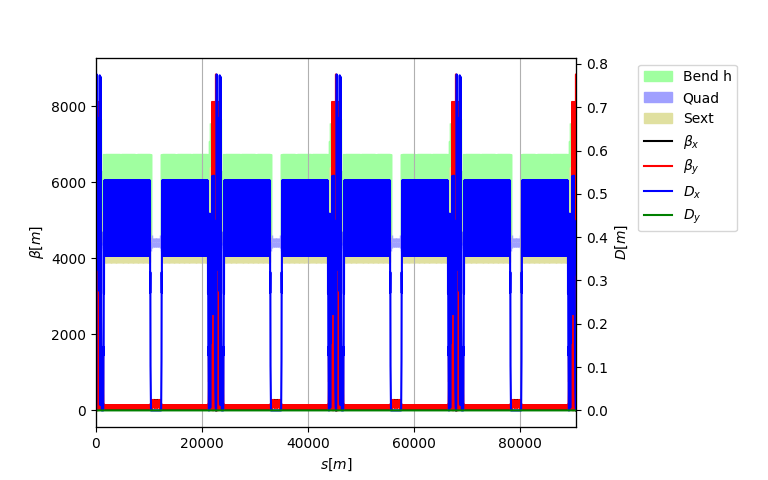

In [144]:
tw.plot()

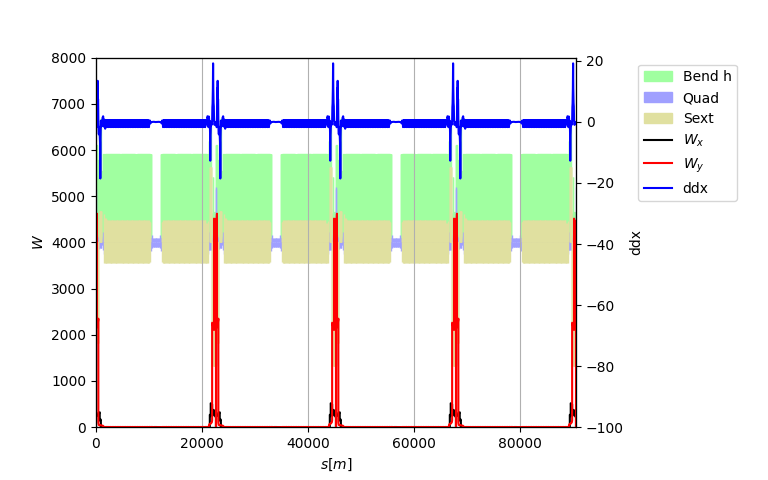

In [145]:
pp = tw.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=8000, right_lo=-100)

In [146]:
line.replace_all_repeated_elements()

In [147]:
# tw_ng = line.madng_twiss(rdts=['f1200', 'f2100', 'f3000'])

In [148]:
# tw_ng.plot('abs(f1200) abs(f2100) abs(f3000)')

In [132]:
tw.qy

np.float64(176.29983445075803)

In [133]:
line['rf_on'] = True
line['rf_lag'] = 0.5

In [134]:
tw6d = line.twiss()

In [135]:
print('qs', tw6d.qs)
print('zeta', tw6d.zeta[0])

qs 0.04952401889033936
zeta 0.0


<Figure size 640x480 with 0 Axes>

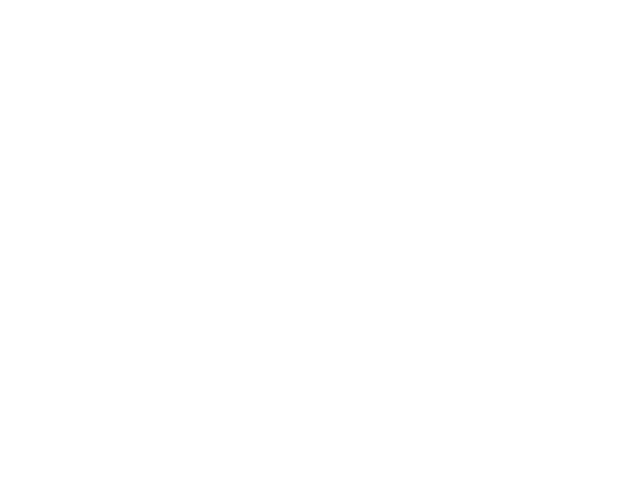

In [136]:
import sys
from momentum_acceptance import ActionMomentumAcceptance # reusing code from K. Skoufaris
nemitt_x = 6.33e-5
nemitt_y = 1.69e-7
energy_spread=3.9e-4
nn_y_r=15
max_y_r=10
global_xy_limit = 1e-2
num_turns = 50
act = ActionMomentumAcceptance(line,
            nemitt_x, nemitt_y, nn_y_r, max_y_r, energy_spread,
            global_xy_limit=global_xy_limit, num_turns=num_turns)

plt.figure()
_ = act.mom_acceptance(plot=True, with_progress=1)
plt.subplots_adjust(hspace=0.4)

### Match a tune knob

In [100]:
tw0 = line.twiss4d()
opt = line.match_knob(
    run=False,
    method='4d',
    knob_name='dqy',
    knob_value_start=0,
    knob_value_end=5e-3,
    vary=xt.VaryList(['kqd1', 'kqf2', 'kqd3', 'kqf4', 'kqd5', 'kqf6'], step=1e-9),
    targets=xt.TargetSet(qx=tw0.qx, qy=tw0.qy+5e-3)
) 

In [101]:
opt = line.match_knob(
    run=False,
    method='4d',
    knob_name='dqx',
    knob_value_start=0,
    knob_value_end=5e-3,
    vary=xt.VaryList(['kqd1', 'kqf2', 'kqd3', 'kqf4', 'kqd5', 'kqf6'], step=1e-9),
    targets=xt.TargetSet(qx=tw0.qx+5e-3, qy=tw0.qy)
) 
opt.solve()
opt.generate_knob()

                                             
Optimize - start penalty: 0.05                              
Matching: model call n. 17 penalty = 1.1625e-10              
Optimize - end penalty:  1.1625e-10                            
Generated knob:  dqx


### Change the tune using the knob

In [83]:
line.vars.get_table().rows['ks.*']

VarsTable: 106 rows, 3 cols
name           value expr                    
ksf2        0.244198 ksffam2                 
ksd1       -0.270221 ksdfam1                 
ksf1        0.281818 ksffam1                 
ksd2       -0.156071 ksdfam2                 
ksf4               0 None                    
ksd3               0 None                    
ksf3               0 None                    
ksd4               0 None                    
ksd2ul    -0.0985156 (ksdfam2 + ksd2ul_delta)
ksf1ul      0.268074 (ksffam1 + ksf1ul_delta)
...
ksf1bl3_delta     -0.146936 None
ksf2bl3_delta   0.000130721 None
ksf2fl_delta     0.00411878 None
ksf1fl_delta    -0.00726064 None
ksf1fr_delta      0.0347678 None
ksf2fr_delta       0.116073 None
ksf2br3_delta     0.0216243 None
ksf1br3_delta      0.025442 None
ksf1ar3_delta     -0.019629 None
ksf2ar3_delta     0.0722222 None

In [37]:
tt=line.twiss4d()
print(f'qx={tt.qx:.3f} qy={tt.qy:.3f}')

qx=198.200 qy=176.300


In [38]:
line['dqx'] = 0

In [77]:
p = line.build_particles(x=10e-5, y=0.3e-5)

In [78]:
line.track(p, num_turns=10000, turn_by_turn_monitor=True, with_progress=100)

Tracking:   0%|          | 0/10000 [00:00<?, ?it/s]

In [79]:
mon = line.record_last_track

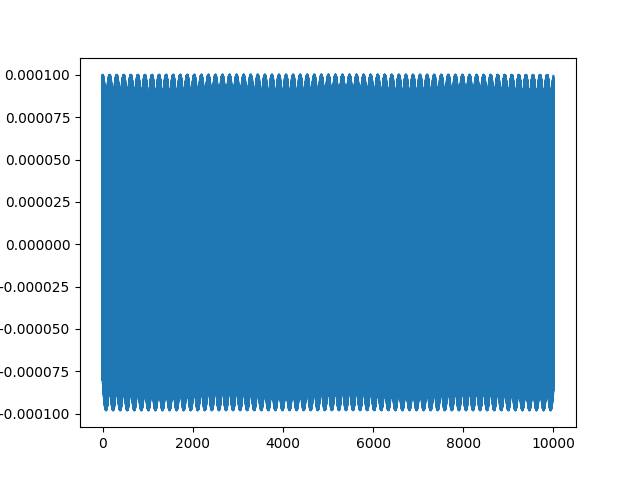

In [80]:
plt.figure()
plt.plot(mon.x.T)

Tracking:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

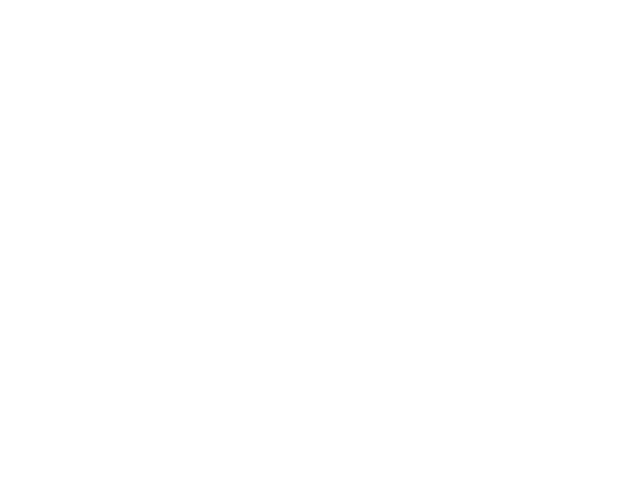

In [127]:
plt.figure()
_ = act.mom_acceptance(plot=True, with_progress=1)
plt.subplots_adjust(hspace=0.4)

In [54]:
line['rf_on'] = 0
twng2 = line.madng_twiss(normal_form=False)

In [56]:
twng2.qx

np.float64(198.0001160807562)

In [65]:
fp = line.get_footprint(nemitt_x = 6.33e-5, nemitt_y = 1.69e-7, freeze_longitudinal=True)

Tracking particles for footprint...
Done tracking.
Done computing footprint.


In [113]:
p = line.build_particles(x=1e-6)

In [118]:
line['rf_on'] = 1
line.track(p, num_turns=1000, turn_by_turn_monitor=True)

In [119]:
mon = line.record_last_track

In [120]:
line.twiss4d().qx

np.float64(198.0001160807562)

In [121]:
nafflib.get_tune(mon.x[0, :])

-0.001953125

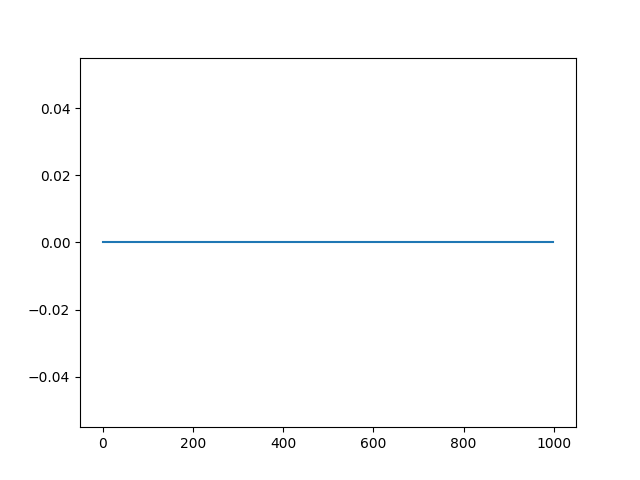

In [122]:
plt.figure()
plt.plot(mon.x.T)

In [79]:
out

(array([-1.]), array([-3.65653236e-07+0.j]))

In [109]:
mon.x.shape

(1, 1000)

In [110]:
tw = line.twiss4d()

In [111]:
tw.dqx

np.float64(733.9713195915465)

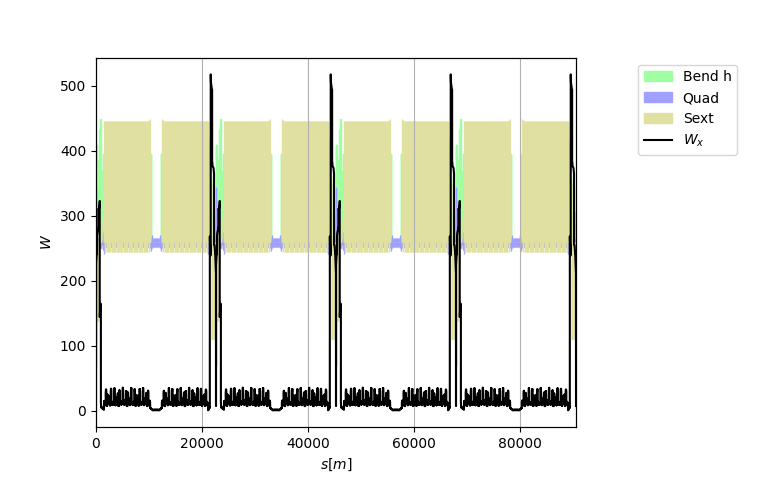

In [112]:
tw.plot('wx_chrom')

In [115]:
tt = line.twiss4d(delta0=5e-3)

In [116]:
tt.qx

np.float64(201.81701994167634)

In [117]:
tw.qx

np.float64(198.20018903751375)

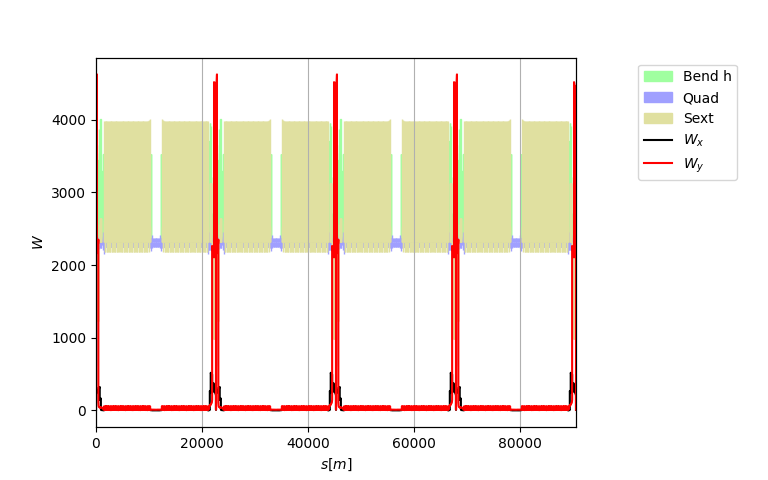

In [118]:
tw.plot('wx_chrom wy_chrom')